<h1>Приведение данных</h1>

In [1]:
import zipfile
import os

Для начала распакуем наши данные:

In [2]:
print(os.listdir())

with zipfile.ZipFile("plates.zip", "r") as data:
    data.extractall()
    
print(os.listdir())

['.git', '.ipynb_checkpoints', 'Clear vs Dirty.ipynb', 'debug.log', 'plates', 'plates.zip', 'sample_submission.csv', 'submission.csv', 'test', 'train', 'val', '__MACOSX']
['.git', '.ipynb_checkpoints', 'Clear vs Dirty.ipynb', 'debug.log', 'plates', 'plates.zip', 'sample_submission.csv', 'submission.csv', 'test', 'train', 'val', '__MACOSX']


In [3]:
data_root = "plates"

Создадим папки для валидации и тренировки.

In [4]:
train_dir = "train"
val_dir = "val"

class_names = ["cleaned", "dirty"]

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

Заполним папку для трейна и валидации, чтобы в валидацию передавать каждое 6-ое изображение. (Для проверки качества модели)

In [5]:
import shutil
from tqdm import tqdm

for class_name in class_names:
    source_dir = os.path.join(data_root, "train", class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 5 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████████████████████████████████████| 21/21 [00:00<00:00, 32.38it/s]



<h1>Аугментация изображений</h1>

Так как у нас достаточно мало данных, то нам необходимо увеличить их количества с помощью аугментаций (Повороты, отзеркаливание и т п).

In [6]:
# !pip install pytorch
# !conda install -c pytorch torchvision

In [7]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy

In [8]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True

Выполним аугментацию.

In [242]:
def add_transforms(dir_name, transformations=[]):
    basic_transforms = [
        transforms.CenterCrop((224, 224)),
        transforms.ColorJitter(brightness=0, contrast=(1.5, 1.75), saturation=(1.25, 1.5), hue=(0.3, 0.4)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ]
    
    all_images = [torchvision.datasets.ImageFolder(dir_name, transforms.Compose(basic_transforms[:]))]
    
    for transformation in transformations:
        basic_transforms.insert(0, transformation)
        all_images += [torchvision.datasets.ImageFolder(dir_name, transforms.Compose(basic_transforms[:]))]
        
    return torch.utils.data.ConcatDataset(all_images)

In [243]:
import torch
import torchvision
from torchvision import transforms, models

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True

train_transforms = [transforms.RandomRotation(30), transforms.RandomVerticalFlip(p=1.0), transforms.RandomHorizontalFlip(p=1.0)]
# train_transforms = [transforms.Grayscale(3)]

val_transforms = [transforms.RandomRotation(30), transforms.RandomHorizontalFlip(p=1.0), transforms.RandomVerticalFlip(p=1.0)]

train_dataset = add_transforms(train_dir, train_transforms)

val_dataset = add_transforms(val_dir, val_transforms)
                             
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size
)

In [244]:
itr = iter(train_dataloader)
print(len(train_dataloader), len(train_dataset))
print(len(val_dataloader), len(val_dataset))

8 128
2 32


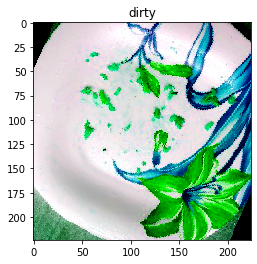

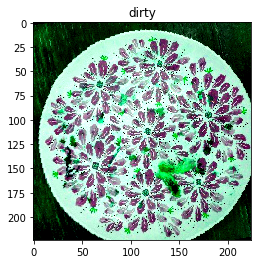

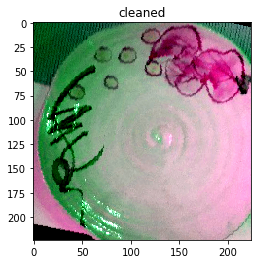

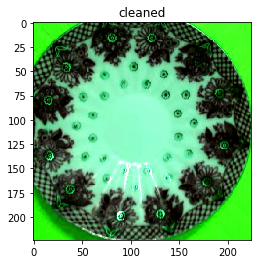

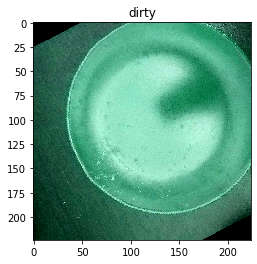

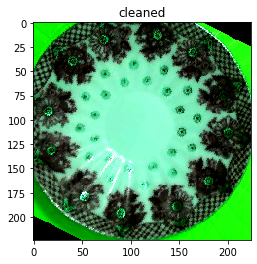

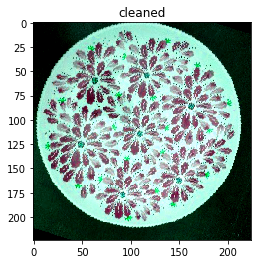

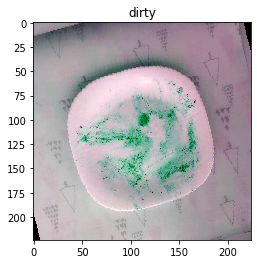

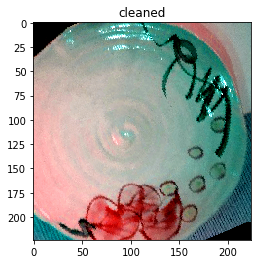

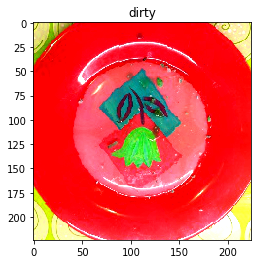

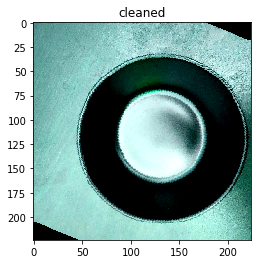

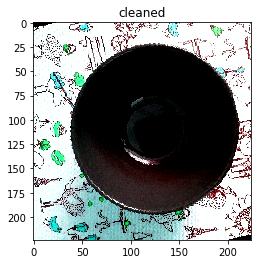

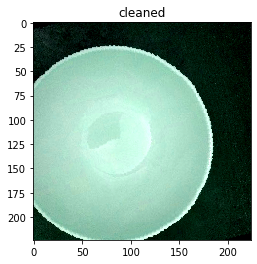

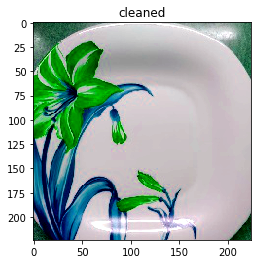

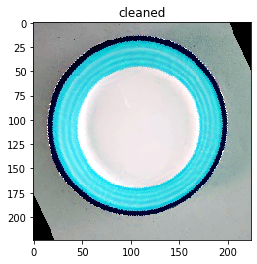

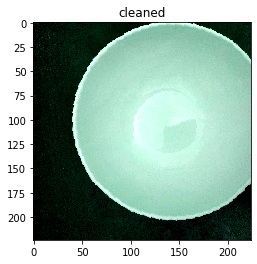

In [245]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def show_input(input_tensor, title=""):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = image * std + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(itr)

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

<h1>Обучение модели</h1>

In [246]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print("Epoch {}/{}:".format(epoch, num_epochs - 1), flush=True)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()
            
            running_loss = 0
            running_acc = 0
            
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
                    
                    if phase == "train":
                        loss_value.backward()
                        optimizer.step()
                        
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()
            
            if phase == "train":
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc), flush=True) 
            
    return model

<h1>Архитектура модели</h1>

Возьмем предобученную сеть ResNet18 и дообучим ее до нашей задачи. Не забыв про регуляризацию. Иначе после 3 эпохи качество модели падает с 82% до 54%.

In [272]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True

model = models.resnet50(pretrained=True)

# Запретим изменение весов
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Каждые 7 итераций уменьшает lr на 0.1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

<h1>Тренировка модели</h1>

In [273]:
train_model(model, loss, optimizer, scheduler, num_epochs=31) 

Epoch 0/30:





  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:22<02:39, 22.73s/it]


 25%|███████████                                 | 2/8 [00:26<01:42, 17.07s/it]


 38%|████████████████▌                           | 3/8 [00:29<01:04, 12.87s/it]


 50%|██████████████████████                      | 4/8 [00:32<00:39,  9.91s/it]


 62%|███████████████████████████▌                | 5/8 [00:35<00:23,  7.84s/it]


 75%|█████████████████████████████████           | 6/8 [00:38<00:12,  6.37s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:41<00:05,  5.37s/it]


100%|████████████████████████████████████████████| 8/8 [00:46<00:00,  5.75s/it]

train Loss: 0.7256 Acc: 0.4922






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:12<00:12, 12.03s/it]


100%|████████████████████████████████████████████| 2/2 [00:15<00:00,  7.92s/it]

val Loss: 0.6256 Acc: 0.7188
Epoch 1/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:10<01:14, 10.61s/it]


 25%|███████████                                 | 2/8 [00:13<00:50,  8.36s/it]


 38%|████████████████▌                           | 3/8 [00:16<00:33,  6.74s/it]


 50%|██████████████████████                      | 4/8 [00:19<00:22,  5.60s/it]


 62%|███████████████████████████▌                | 5/8 [00:22<00:14,  4.79s/it]


 75%|█████████████████████████████████           | 6/8 [00:25<00:08,  4.25s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:28<00:03,  3.86s/it]


100%|████████████████████████████████████████████| 8/8 [00:32<00:00,  4.02s/it]

train Loss: 0.5452 Acc: 0.7188






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:11<00:11, 11.63s/it]


100%|████████████████████████████████████████████| 2/2 [00:16<00:00,  8.20s/it]

val Loss: 0.5952 Acc: 0.5938
Epoch 2/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:14<01:44, 14.97s/it]


 25%|███████████                                 | 2/8 [00:18<01:09, 11.62s/it]


 38%|████████████████▌                           | 3/8 [00:22<00:46,  9.28s/it]


 50%|██████████████████████                      | 4/8 [00:26<00:30,  7.53s/it]


 62%|███████████████████████████▌                | 5/8 [00:30<00:19,  6.60s/it]


 75%|█████████████████████████████████           | 6/8 [00:34<00:11,  5.90s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:39<00:05,  5.43s/it]


100%|████████████████████████████████████████████| 8/8 [00:44<00:00,  5.52s/it]

train Loss: 0.4320 Acc: 0.8750






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:11<00:11, 11.84s/it]


100%|████████████████████████████████████████████| 2/2 [00:15<00:00,  7.91s/it]

val Loss: 0.4908 Acc: 0.8750
Epoch 3/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:14<01:42, 14.58s/it]


 25%|███████████                                 | 2/8 [00:18<01:08, 11.50s/it]


 38%|████████████████▌                           | 3/8 [00:21<00:44,  8.96s/it]


 50%|██████████████████████                      | 4/8 [00:24<00:28,  7.18s/it]


 62%|███████████████████████████▌                | 5/8 [00:28<00:18,  6.08s/it]


 75%|█████████████████████████████████           | 6/8 [00:31<00:10,  5.21s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:36<00:04,  4.96s/it]


100%|████████████████████████████████████████████| 8/8 [00:41<00:00,  5.16s/it]

train Loss: 0.4148 Acc: 0.8438






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:12<00:12, 12.54s/it]


100%|████████████████████████████████████████████| 2/2 [00:16<00:00,  8.19s/it]

val Loss: 0.4842 Acc: 0.8750
Epoch 4/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:10<01:15, 10.84s/it]


 25%|███████████                                 | 2/8 [00:14<00:51,  8.56s/it]


 38%|████████████████▌                           | 3/8 [00:17<00:35,  7.02s/it]


 50%|██████████████████████                      | 4/8 [00:21<00:24,  6.19s/it]


 62%|███████████████████████████▌                | 5/8 [00:24<00:15,  5.23s/it]


 75%|█████████████████████████████████           | 6/8 [00:27<00:09,  4.61s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:32<00:04,  4.47s/it]


100%|████████████████████████████████████████████| 8/8 [00:35<00:00,  4.48s/it]

train Loss: 0.3904 Acc: 0.8594






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:11<00:11, 11.07s/it]


100%|████████████████████████████████████████████| 2/2 [00:14<00:00,  7.48s/it]

val Loss: 0.4660 Acc: 0.8125
Epoch 5/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:11<01:19, 11.36s/it]


 25%|███████████                                 | 2/8 [00:14<00:54,  9.04s/it]


 38%|████████████████▌                           | 3/8 [00:18<00:37,  7.44s/it]


 50%|██████████████████████                      | 4/8 [00:21<00:24,  6.16s/it]


 62%|███████████████████████████▌                | 5/8 [00:25<00:16,  5.50s/it]


 75%|█████████████████████████████████           | 6/8 [00:29<00:09,  4.98s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:32<00:04,  4.41s/it]


100%|████████████████████████████████████████████| 8/8 [00:36<00:00,  4.58s/it]

train Loss: 0.2883 Acc: 0.9375






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:15<00:15, 15.74s/it]


100%|████████████████████████████████████████████| 2/2 [00:19<00:00,  9.86s/it]

val Loss: 0.4741 Acc: 0.8438
Epoch 6/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:12<01:29, 12.73s/it]


 25%|███████████                                 | 2/8 [00:15<00:58,  9.82s/it]


 38%|████████████████▌                           | 3/8 [00:18<00:38,  7.76s/it]


 50%|██████████████████████                      | 4/8 [00:21<00:25,  6.32s/it]


 62%|███████████████████████████▌                | 5/8 [00:24<00:15,  5.32s/it]


 75%|█████████████████████████████████           | 6/8 [00:27<00:09,  4.62s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:30<00:04,  4.10s/it]


100%|████████████████████████████████████████████| 8/8 [00:34<00:00,  4.28s/it]

train Loss: 0.2708 Acc: 0.9766






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:10<00:10, 10.18s/it]


100%|████████████████████████████████████████████| 2/2 [00:14<00:00,  7.30s/it]

val Loss: 0.4789 Acc: 0.8438
Epoch 7/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:15<01:49, 15.59s/it]


 25%|███████████                                 | 2/8 [00:19<01:13, 12.23s/it]


 38%|████████████████▌                           | 3/8 [00:23<00:48,  9.68s/it]


 50%|██████████████████████                      | 4/8 [00:28<00:32,  8.15s/it]


 62%|███████████████████████████▌                | 5/8 [00:32<00:21,  7.06s/it]


 75%|█████████████████████████████████           | 6/8 [00:37<00:12,  6.30s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:40<00:05,  5.42s/it]


100%|████████████████████████████████████████████| 8/8 [00:45<00:00,  5.69s/it]

train Loss: 0.3129 Acc: 0.9453






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:13<00:13, 13.29s/it]


100%|████████████████████████████████████████████| 2/2 [00:18<00:00,  9.17s/it]

val Loss: 0.4379 Acc: 0.8750
Epoch 8/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:14<01:44, 14.89s/it]


 25%|███████████                                 | 2/8 [00:17<01:08, 11.35s/it]


 38%|████████████████▌                           | 3/8 [00:20<00:44,  8.83s/it]


 50%|██████████████████████                      | 4/8 [00:23<00:28,  7.07s/it]


 62%|███████████████████████████▌                | 5/8 [00:26<00:17,  5.83s/it]


 75%|█████████████████████████████████           | 6/8 [00:29<00:09,  4.95s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:32<00:04,  4.34s/it]


100%|████████████████████████████████████████████| 8/8 [00:36<00:00,  4.54s/it]

train Loss: 0.2994 Acc: 0.9297






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:11<00:11, 11.43s/it]


100%|████████████████████████████████████████████| 2/2 [00:15<00:00,  7.95s/it]

val Loss: 0.4663 Acc: 0.8125
Epoch 9/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:15<01:47, 15.41s/it]


 25%|███████████                                 | 2/8 [00:19<01:12, 12.04s/it]


 38%|████████████████▌                           | 3/8 [00:23<00:47,  9.52s/it]


 50%|██████████████████████                      | 4/8 [00:27<00:31,  7.80s/it]


 62%|███████████████████████████▌                | 5/8 [00:31<00:20,  6.75s/it]


 75%|█████████████████████████████████           | 6/8 [00:35<00:12,  6.08s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:40<00:05,  5.60s/it]


100%|████████████████████████████████████████████| 8/8 [00:45<00:00,  5.74s/it]

train Loss: 0.3046 Acc: 0.9219






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:12<00:12, 12.66s/it]


100%|████████████████████████████████████████████| 2/2 [00:17<00:00,  8.74s/it]

val Loss: 0.4775 Acc: 0.8125
Epoch 10/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:14<01:38, 14.11s/it]


 25%|███████████                                 | 2/8 [00:17<01:05, 10.84s/it]


 38%|████████████████▌                           | 3/8 [00:20<00:42,  8.53s/it]


 50%|██████████████████████                      | 4/8 [00:23<00:27,  6.93s/it]


 62%|███████████████████████████▌                | 5/8 [00:26<00:17,  5.80s/it]


 75%|█████████████████████████████████           | 6/8 [00:30<00:10,  5.02s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:33<00:04,  4.41s/it]


100%|████████████████████████████████████████████| 8/8 [00:36<00:00,  4.60s/it]

train Loss: 0.2922 Acc: 0.9297






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:11<00:11, 11.41s/it]


100%|████████████████████████████████████████████| 2/2 [00:15<00:00,  7.61s/it]

val Loss: 0.5171 Acc: 0.7188
Epoch 11/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:10<01:15, 10.83s/it]


 25%|███████████                                 | 2/8 [00:13<00:51,  8.51s/it]


 38%|████████████████▌                           | 3/8 [00:17<00:34,  6.94s/it]


 50%|██████████████████████                      | 4/8 [00:20<00:23,  5.76s/it]


 62%|███████████████████████████▌                | 5/8 [00:23<00:14,  4.92s/it]


 75%|█████████████████████████████████           | 6/8 [00:26<00:08,  4.35s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:29<00:03,  3.99s/it]


100%|████████████████████████████████████████████| 8/8 [00:33<00:00,  4.13s/it]

train Loss: 0.2958 Acc: 0.9375






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:10<00:10, 10.31s/it]


100%|████████████████████████████████████████████| 2/2 [00:14<00:00,  7.12s/it]

val Loss: 0.4899 Acc: 0.7812
Epoch 12/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:10<01:16, 10.86s/it]


 25%|███████████                                 | 2/8 [00:13<00:50,  8.49s/it]


 38%|████████████████▌                           | 3/8 [00:16<00:34,  6.84s/it]


 50%|██████████████████████                      | 4/8 [00:19<00:22,  5.69s/it]


 62%|███████████████████████████▌                | 5/8 [00:22<00:14,  4.88s/it]


 75%|█████████████████████████████████           | 6/8 [00:25<00:08,  4.31s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:28<00:03,  3.92s/it]


100%|████████████████████████████████████████████| 8/8 [00:32<00:00,  4.07s/it]

train Loss: 0.3049 Acc: 0.8984






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:09<00:09,  9.96s/it]


100%|████████████████████████████████████████████| 2/2 [00:13<00:00,  6.84s/it]

val Loss: 0.5081 Acc: 0.7812
Epoch 13/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:10<01:14, 10.69s/it]


 25%|███████████                                 | 2/8 [00:13<00:50,  8.39s/it]


 38%|████████████████▌                           | 3/8 [00:16<00:33,  6.77s/it]


 50%|██████████████████████                      | 4/8 [00:19<00:22,  5.62s/it]


 62%|███████████████████████████▌                | 5/8 [00:22<00:14,  4.89s/it]


 75%|█████████████████████████████████           | 6/8 [00:25<00:08,  4.33s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:28<00:03,  3.93s/it]


100%|████████████████████████████████████████████| 8/8 [00:32<00:00,  4.07s/it]

train Loss: 0.2695 Acc: 0.9375






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:10<00:10, 10.17s/it]


100%|████████████████████████████████████████████| 2/2 [00:14<00:00,  7.04s/it]

val Loss: 0.4656 Acc: 0.8438
Epoch 14/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:11<01:18, 11.16s/it]


 25%|███████████                                 | 2/8 [00:14<00:52,  8.71s/it]


 38%|████████████████▌                           | 3/8 [00:17<00:34,  7.00s/it]


 50%|██████████████████████                      | 4/8 [00:20<00:23,  5.79s/it]


 62%|███████████████████████████▌                | 5/8 [00:23<00:14,  4.95s/it]


 75%|█████████████████████████████████           | 6/8 [00:26<00:08,  4.36s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:29<00:03,  3.95s/it]


100%|████████████████████████████████████████████| 8/8 [00:32<00:00,  4.11s/it]

train Loss: 0.2755 Acc: 0.9531






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:10<00:10, 10.23s/it]


100%|████████████████████████████████████████████| 2/2 [00:13<00:00,  6.97s/it]

val Loss: 0.4338 Acc: 0.8125
Epoch 15/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:10<01:16, 10.96s/it]


 25%|███████████                                 | 2/8 [00:14<00:51,  8.60s/it]


 38%|████████████████▌                           | 3/8 [00:17<00:34,  6.94s/it]


 50%|██████████████████████                      | 4/8 [00:20<00:23,  5.80s/it]


 62%|███████████████████████████▌                | 5/8 [00:23<00:15,  5.02s/it]


 75%|█████████████████████████████████           | 6/8 [00:26<00:09,  4.51s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:29<00:04,  4.06s/it]


100%|████████████████████████████████████████████| 8/8 [00:33<00:00,  4.20s/it]

train Loss: 0.3025 Acc: 0.9219






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:11<00:11, 11.66s/it]


100%|████████████████████████████████████████████| 2/2 [00:15<00:00,  7.69s/it]

val Loss: 0.4476 Acc: 0.8125
Epoch 16/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:10<01:14, 10.69s/it]


 25%|███████████                                 | 2/8 [00:13<00:50,  8.46s/it]


 38%|████████████████▌                           | 3/8 [00:17<00:34,  6.86s/it]


 50%|██████████████████████                      | 4/8 [00:20<00:22,  5.71s/it]


 62%|███████████████████████████▌                | 5/8 [00:23<00:14,  4.98s/it]


 75%|█████████████████████████████████           | 6/8 [00:26<00:08,  4.38s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:29<00:03,  3.98s/it]


100%|████████████████████████████████████████████| 8/8 [00:33<00:00,  4.16s/it]

train Loss: 0.2791 Acc: 0.9375






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:11<00:11, 11.29s/it]


100%|████████████████████████████████████████████| 2/2 [00:15<00:00,  7.63s/it]

val Loss: 0.4642 Acc: 0.8125
Epoch 17/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:11<01:17, 11.03s/it]


 25%|███████████                                 | 2/8 [00:14<00:51,  8.65s/it]


 38%|████████████████▌                           | 3/8 [00:17<00:34,  6.99s/it]


 50%|██████████████████████                      | 4/8 [00:20<00:23,  5.87s/it]


 62%|███████████████████████████▌                | 5/8 [00:23<00:15,  5.05s/it]


 75%|█████████████████████████████████           | 6/8 [00:26<00:08,  4.46s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:29<00:04,  4.03s/it]


100%|████████████████████████████████████████████| 8/8 [00:33<00:00,  4.20s/it]

train Loss: 0.2821 Acc: 0.9688






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:11<00:11, 11.17s/it]


100%|████████████████████████████████████████████| 2/2 [00:15<00:00,  7.55s/it]

val Loss: 0.4899 Acc: 0.7812
Epoch 18/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:10<01:15, 10.84s/it]


 25%|███████████                                 | 2/8 [00:13<00:51,  8.52s/it]


 38%|████████████████▌                           | 3/8 [00:17<00:34,  6.88s/it]


 50%|██████████████████████                      | 4/8 [00:20<00:22,  5.73s/it]


 62%|███████████████████████████▌                | 5/8 [00:23<00:14,  4.93s/it]


 75%|█████████████████████████████████           | 6/8 [00:26<00:08,  4.38s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:29<00:03,  3.99s/it]


100%|████████████████████████████████████████████| 8/8 [00:33<00:00,  4.13s/it]

train Loss: 0.2782 Acc: 0.9453






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:11<00:11, 11.31s/it]


100%|████████████████████████████████████████████| 2/2 [00:15<00:00,  7.66s/it]

val Loss: 0.4241 Acc: 0.8438
Epoch 19/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:10<01:16, 10.89s/it]


 25%|███████████                                 | 2/8 [00:13<00:51,  8.54s/it]


 38%|████████████████▌                           | 3/8 [00:17<00:34,  6.90s/it]


 50%|██████████████████████                      | 4/8 [00:20<00:22,  5.74s/it]


 62%|███████████████████████████▌                | 5/8 [00:23<00:14,  4.94s/it]


 75%|█████████████████████████████████           | 6/8 [00:26<00:08,  4.37s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:29<00:03,  3.97s/it]


100%|████████████████████████████████████████████| 8/8 [00:33<00:00,  4.13s/it]

train Loss: 0.2738 Acc: 0.9297






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:11<00:11, 11.03s/it]


100%|████████████████████████████████████████████| 2/2 [00:14<00:00,  7.39s/it]

val Loss: 0.4524 Acc: 0.7812
Epoch 20/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:10<01:14, 10.70s/it]


 25%|███████████                                 | 2/8 [00:13<00:50,  8.43s/it]


 38%|████████████████▌                           | 3/8 [00:16<00:33,  6.79s/it]


 50%|██████████████████████                      | 4/8 [00:19<00:22,  5.65s/it]


 62%|███████████████████████████▌                | 5/8 [00:22<00:14,  4.86s/it]


 75%|█████████████████████████████████           | 6/8 [00:25<00:08,  4.29s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:28<00:03,  3.91s/it]


100%|████████████████████████████████████████████| 8/8 [00:32<00:00,  4.06s/it]

train Loss: 0.2683 Acc: 0.9453






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:10<00:10, 10.31s/it]


100%|████████████████████████████████████████████| 2/2 [00:14<00:00,  7.05s/it]

val Loss: 0.4866 Acc: 0.7812
Epoch 21/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:10<01:14, 10.67s/it]


 25%|███████████                                 | 2/8 [00:13<00:50,  8.38s/it]


 38%|████████████████▌                           | 3/8 [00:16<00:33,  6.76s/it]


 50%|██████████████████████                      | 4/8 [00:19<00:22,  5.64s/it]


 62%|███████████████████████████▌                | 5/8 [00:22<00:14,  4.88s/it]


 75%|█████████████████████████████████           | 6/8 [00:25<00:08,  4.35s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:28<00:03,  3.94s/it]


100%|████████████████████████████████████████████| 8/8 [00:32<00:00,  4.08s/it]

train Loss: 0.3173 Acc: 0.8828






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:10<00:10, 10.19s/it]


100%|████████████████████████████████████████████| 2/2 [00:14<00:00,  7.01s/it]

val Loss: 0.4414 Acc: 0.8125
Epoch 22/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:10<01:16, 10.95s/it]


 25%|███████████                                 | 2/8 [00:13<00:51,  8.57s/it]


 38%|████████████████▌                           | 3/8 [00:16<00:34,  6.89s/it]


 50%|██████████████████████                      | 4/8 [00:19<00:22,  5.71s/it]


 62%|███████████████████████████▌                | 5/8 [00:22<00:14,  4.90s/it]


 75%|█████████████████████████████████           | 6/8 [00:25<00:08,  4.32s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:28<00:03,  3.95s/it]


100%|████████████████████████████████████████████| 8/8 [00:32<00:00,  4.09s/it]

train Loss: 0.2760 Acc: 0.9375






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:10<00:10, 10.51s/it]


100%|████████████████████████████████████████████| 2/2 [00:14<00:00,  7.25s/it]

val Loss: 0.5020 Acc: 0.7500
Epoch 23/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:10<01:15, 10.82s/it]


 25%|███████████                                 | 2/8 [00:13<00:51,  8.51s/it]


 38%|████████████████▌                           | 3/8 [00:16<00:34,  6.87s/it]


 50%|██████████████████████                      | 4/8 [00:20<00:22,  5.72s/it]


 62%|███████████████████████████▌                | 5/8 [00:23<00:14,  4.90s/it]


 75%|█████████████████████████████████           | 6/8 [00:25<00:08,  4.31s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:28<00:03,  3.91s/it]


100%|████████████████████████████████████████████| 8/8 [00:32<00:00,  4.09s/it]

train Loss: 0.3076 Acc: 0.9297






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:10<00:10, 10.82s/it]


100%|████████████████████████████████████████████| 2/2 [00:14<00:00,  7.24s/it]

val Loss: 0.4428 Acc: 0.8438
Epoch 24/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:11<01:20, 11.46s/it]


 25%|███████████                                 | 2/8 [00:14<00:53,  8.93s/it]


 38%|████████████████▌                           | 3/8 [00:17<00:35,  7.14s/it]


 50%|██████████████████████                      | 4/8 [00:20<00:23,  5.89s/it]


 62%|███████████████████████████▌                | 5/8 [00:23<00:15,  5.03s/it]


 75%|█████████████████████████████████           | 6/8 [00:26<00:08,  4.42s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:29<00:04,  4.01s/it]


100%|████████████████████████████████████████████| 8/8 [00:33<00:00,  4.15s/it]

train Loss: 0.3212 Acc: 0.9062






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:10<00:10, 10.14s/it]


100%|████████████████████████████████████████████| 2/2 [00:13<00:00,  6.92s/it]

val Loss: 0.4309 Acc: 0.8125
Epoch 25/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:10<01:13, 10.55s/it]


 25%|███████████                                 | 2/8 [00:13<00:49,  8.28s/it]


 38%|████████████████▌                           | 3/8 [00:16<00:33,  6.71s/it]


 50%|██████████████████████                      | 4/8 [00:19<00:22,  5.58s/it]


 62%|███████████████████████████▌                | 5/8 [00:22<00:14,  4.80s/it]


 75%|█████████████████████████████████           | 6/8 [00:25<00:08,  4.26s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:28<00:03,  3.87s/it]


100%|████████████████████████████████████████████| 8/8 [00:32<00:00,  4.03s/it]

train Loss: 0.3107 Acc: 0.9062






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:09<00:09,  9.95s/it]


100%|████████████████████████████████████████████| 2/2 [00:13<00:00,  6.82s/it]

val Loss: 0.4708 Acc: 0.8125
Epoch 26/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:10<01:15, 10.72s/it]


 25%|███████████                                 | 2/8 [00:13<00:50,  8.40s/it]


 38%|████████████████▌                           | 3/8 [00:16<00:33,  6.78s/it]


 50%|██████████████████████                      | 4/8 [00:19<00:22,  5.64s/it]


 62%|███████████████████████████▌                | 5/8 [00:22<00:14,  4.85s/it]


 75%|█████████████████████████████████           | 6/8 [00:25<00:08,  4.31s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:28<00:03,  3.92s/it]


100%|████████████████████████████████████████████| 8/8 [00:32<00:00,  4.10s/it]

train Loss: 0.2651 Acc: 0.9844






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:10<00:10, 10.46s/it]


100%|████████████████████████████████████████████| 2/2 [00:14<00:00,  7.09s/it]

val Loss: 0.4629 Acc: 0.7812
Epoch 27/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:10<01:14, 10.67s/it]


 25%|███████████                                 | 2/8 [00:13<00:50,  8.38s/it]


 38%|████████████████▌                           | 3/8 [00:16<00:33,  6.75s/it]


 50%|██████████████████████                      | 4/8 [00:19<00:22,  5.63s/it]


 62%|███████████████████████████▌                | 5/8 [00:22<00:14,  4.84s/it]


 75%|█████████████████████████████████           | 6/8 [00:25<00:08,  4.28s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:28<00:03,  3.89s/it]


100%|████████████████████████████████████████████| 8/8 [00:32<00:00,  4.04s/it]

train Loss: 0.2723 Acc: 0.9531






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:10<00:10, 10.11s/it]


100%|████████████████████████████████████████████| 2/2 [00:13<00:00,  6.94s/it]

val Loss: 0.4627 Acc: 0.8125
Epoch 28/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:10<01:14, 10.59s/it]


 25%|███████████                                 | 2/8 [00:13<00:49,  8.30s/it]


 38%|████████████████▌                           | 3/8 [00:16<00:33,  6.72s/it]


 50%|██████████████████████                      | 4/8 [00:19<00:22,  5.61s/it]


 62%|███████████████████████████▌                | 5/8 [00:22<00:14,  4.83s/it]


 75%|█████████████████████████████████           | 6/8 [00:25<00:08,  4.29s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:28<00:03,  3.90s/it]


100%|████████████████████████████████████████████| 8/8 [00:32<00:00,  4.05s/it]

train Loss: 0.2982 Acc: 0.9219






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:09<00:09,  9.93s/it]


100%|████████████████████████████████████████████| 2/2 [00:13<00:00,  6.82s/it]

val Loss: 0.4728 Acc: 0.7812
Epoch 29/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:10<01:14, 10.65s/it]


 25%|███████████                                 | 2/8 [00:13<00:50,  8.45s/it]


 38%|████████████████▌                           | 3/8 [00:17<00:34,  6.89s/it]


 50%|██████████████████████                      | 4/8 [00:20<00:22,  5.72s/it]


 62%|███████████████████████████▌                | 5/8 [00:23<00:14,  4.92s/it]


 75%|█████████████████████████████████           | 6/8 [00:26<00:08,  4.34s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:29<00:03,  3.93s/it]


100%|████████████████████████████████████████████| 8/8 [00:32<00:00,  4.12s/it]

train Loss: 0.2839 Acc: 0.9219






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:11<00:11, 11.31s/it]


100%|████████████████████████████████████████████| 2/2 [00:15<00:00,  7.55s/it]

val Loss: 0.4856 Acc: 0.8125
Epoch 30/30:






  0%|                                                    | 0/8 [00:00<?, ?it/s]


 12%|█████▌                                      | 1/8 [00:10<01:16, 10.98s/it]


 25%|███████████                                 | 2/8 [00:14<00:51,  8.61s/it]


 38%|████████████████▌                           | 3/8 [00:17<00:34,  6.97s/it]


 50%|██████████████████████                      | 4/8 [00:20<00:23,  5.82s/it]


 62%|███████████████████████████▌                | 5/8 [00:23<00:15,  5.08s/it]


 75%|█████████████████████████████████           | 6/8 [00:26<00:08,  4.46s/it]


 88%|██████████████████████████████████████▌     | 7/8 [00:29<00:04,  4.01s/it]


100%|████████████████████████████████████████████| 8/8 [00:33<00:00,  4.18s/it]

train Loss: 0.2700 Acc: 0.9531






  0%|                                                    | 0/2 [00:00<?, ?it/s]


 50%|██████████████████████                      | 1/2 [00:11<00:11, 11.01s/it]


100%|████████████████████████████████████████████| 2/2 [00:14<00:00,  7.36s/it]

val Loss: 0.4828 Acc: 0.7812


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

<h1>Сохранение результатов</h1>

In [274]:
test_dir = 'test'
# shutil.copytree(os.path.join('plates', 'test'), os.path.join(test_dir, 'unknown'))

In [275]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('test',  transforms.Compose([
        transforms.CenterCrop((224, 224)),
        transforms.ColorJitter(brightness=0, contrast=(1.5, 1.75), saturation=(1.25, 1.5), hue=(0.3, 0.4)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ]))

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [276]:
test_dataloader

In [277]:
model.eval()

test_predictions = []
test_img_paths = []

for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)




  0%|                                                   | 0/47 [00:00<?, ?it/s]


  2%|▉                                          | 1/47 [00:05<03:50,  5.00s/it]


  4%|█▊                                         | 2/47 [00:08<03:26,  4.59s/it]


  6%|██▋                                        | 3/47 [00:14<03:32,  4.83s/it]


  9%|███▋                                       | 4/47 [00:17<03:07,  4.37s/it]


 11%|████▌                                      | 5/47 [00:20<02:49,  4.03s/it]


 13%|█████▍                                     | 6/47 [00:24<02:38,  3.88s/it]


 15%|██████▍                                    | 7/47 [00:27<02:28,  3.72s/it]


 17%|███████▎                                   | 8/47 [00:30<02:20,  3.61s/it]


 19%|████████▏                                  | 9/47 [00:34<02:16,  3.58s/it]


 21%|████████▉                                 | 10/47 [00:37<02:09,  3.49s/it]


 23%|█████████▊                                | 11/47 [00:40<02:03,  3.44s/it]


 26%|████████

In [278]:
itr = iter(test_dataloader)

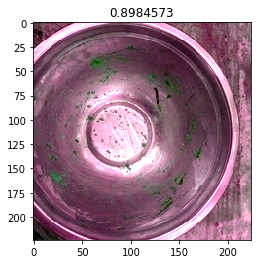

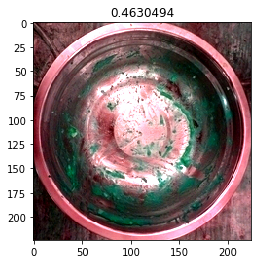

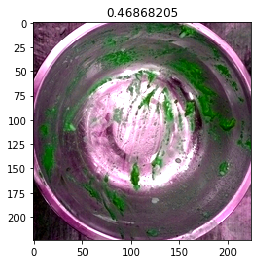

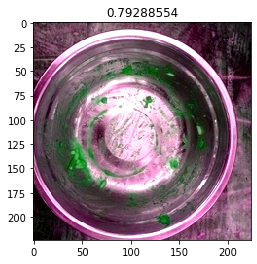

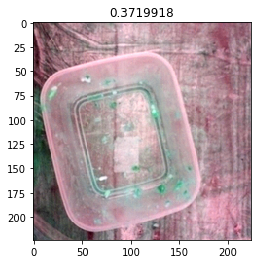

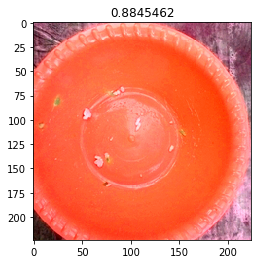

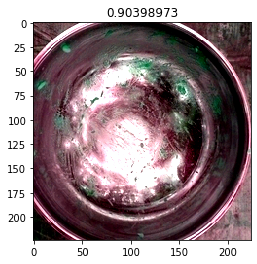

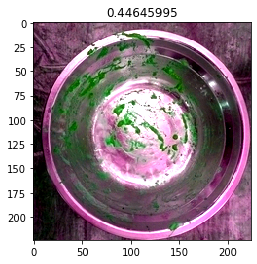

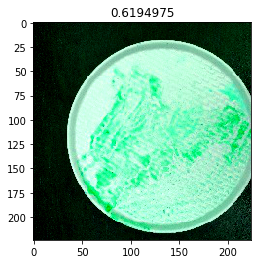

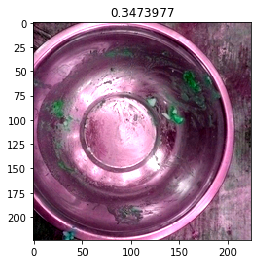

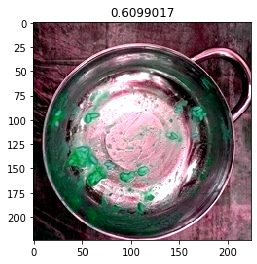

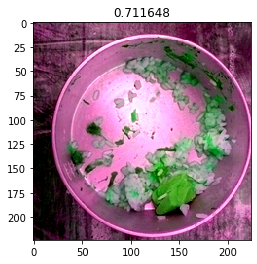

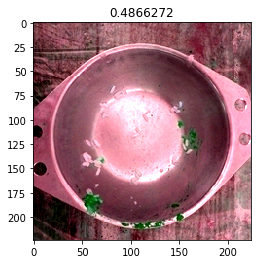

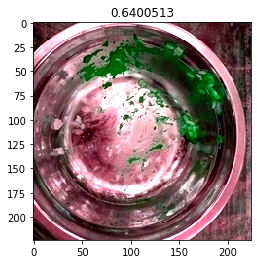

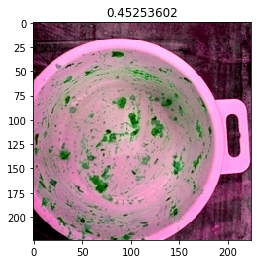

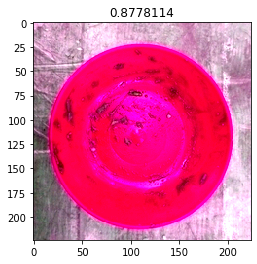

In [281]:
inputs, labels, paths = next(itr)

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [58]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('\\', '').str.replace("testunknown", "")
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

label
id         
0000  dirty
0001  dirty
0002  dirty
0003  dirty
0004  dirty
0005  dirty

In [59]:
submission_df.to_csv('submission.csv')